## Predicted VS True System Class for Flow Reactor Data

In [42]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from util import plot_confusion_matrix
from sklearn.metrics import classification_report

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pandas.read_csv("../xrsdkit_modeling/flowreactor_pd_nanoparticles/models/predicted_pops_and_system_classes.csv")
data.head()

,Unnamed: 0,experiment_id,sample_id,data_file,system_class,diffuse_binary,diffuse_binary_pr,disordered_binary,disordered_binary_pr,crystalline_binary,system_class_pr
0,221,R0_201811,R0_201811_1541372847,gridsearch22_dz_bgsub.dat,diffuse,True,True,False,False,False,diffuse
1,226,R0_201811,R0_201811_1541451179,gridsearch33_dz_bgsub.dat,diffuse,True,True,False,False,False,diffuse__diffuse
2,235,R0_201811,R0_201811_1541312605,gridsearch11_dz_bgsub.dat,diffuse,True,True,False,False,False,diffuse__diffuse
3,244,R0_201811,R0_201811_1541366472,gridsearch20_dz_bgsub.dat,diffuse,True,False,False,False,False,unidentified
4,232,R0_201811,R0_201811_1541364785,gridsearch19_dz_bgsub.dat,diffuse__diffuse,True,True,False,False,False,diffuse


In [3]:
data.system_class.value_counts()

diffuse__diffuse                147
diffuse                          73
unidentified                     37
diffuse__diffuse__disordered     29
diffuse__disordered               7
Name: system_class, dtype: int64

### Prediction of the System Class 

1. Two binary classifiers were trained using "5 folders cross validation" (in the training set we had only samples with "crystalline" = False, this, the model for crystalline was not trained). To avoid having similar samples in the training and testing sets, for each model, the data were grouped in the folders by the first component of PCA. From each train/test split we got the predicted labels for "test" data. After this step each sample had predicted values for "diffuse_binary_pr" and "disordered_binary_pr". 


2. For each combination of "diffuse" and "disordered" labels a multiclass classifier was trained (for this particular dataset each of these classifiers had only two classes, but it is possible that there will be more classes for another dataset, so, we treads these classifiers as "multiclass" classifiers). 

    2.1 For the samples that include only "diffuse" populations, the classifier classified the samples into "diffuse" and "diffuse__diffuse."
    
    2.2 For the samples that include both "diffuse" and "disordered" populations, the classifier classified the samples into "diffuse__disordered" and "diffuse__diffuse__disordered."
    
    
3. Samples with prediction "False" for both "diffuse" and "disordered" populations got label "Unidentified" for the System Class.


4. The inconsistent in the predicted labels was fixed. The samples that were misclassified by binary classifiers had inconsistent System Class. 

    For example, true label: diffuse = True, disordered = True; predicted labels:  diffuse = True, disordered = False. 
    
    When we made the prediction in step 2, we did not take into account predicted labels from binary classifiers. To train the model to distinguish "diffuse__diffuse__disordered" and "diffuse__disordered" we used the samples with true labels "True" for diffuse and disordered populations. Thus, this sample would be classified as "diffuse__diffuse__disordered" or "diffuse__disordered." To fix it, we update the prediction based on predicted values for "diffuse" and "disordered".

### Metrics of predicted System Class

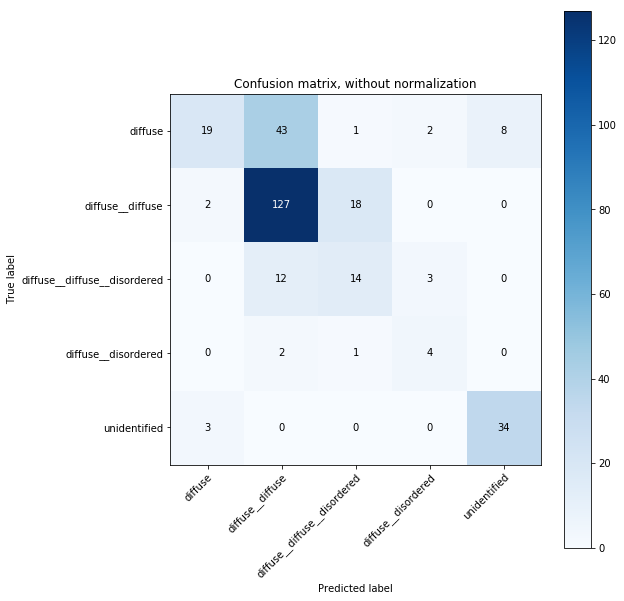

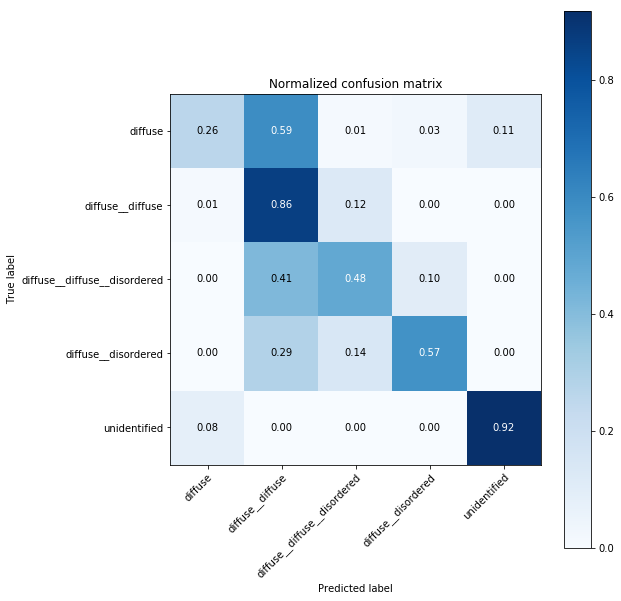

In [14]:
y_true = data['system_class']
y_pred = data['system_class_pr']
class_names = data['system_class'].unique().tolist()
class_names.sort()

plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

This matrix shows that the most common error is predicting "diffuse_diffuse" for the samples with true system class "diffuse" (we predict that the sample has two, not one diffuse population).

The second common error is predicting "diffuse_diffuse" for the samples with true system class "diffuse_diffuse_disordered" (the disordered population is not unidentified for this samples).

This facts can be explained that the majority of the samples has "diffuse_diffuse" system class:

In [15]:
print(classification_report(y_true, y_pred, target_names=class_names))

                              precision    recall  f1-score   support

                     diffuse       0.79      0.26      0.39        73
            diffuse__diffuse       0.69      0.86      0.77       147
diffuse__diffuse__disordered       0.41      0.48      0.44        29
         diffuse__disordered       0.44      0.57      0.50         7
                unidentified       0.81      0.92      0.86        37

                   micro avg       0.68      0.68      0.68       293
                   macro avg       0.63      0.62      0.59       293
                weighted avg       0.70      0.68      0.65       293



from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support :
'micro':
Calculate metrics globally by counting the total true positives, false negatives and false positives.

'macro':
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

'weighted':
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

In [16]:
missclassified = data[data['system_class'] != data['system_class_pr']]
missclassified.shape

(95, 11)

In [17]:
missclassified[['system_class','system_class_pr']].head(15)

,system_class,system_class_pr
1,diffuse,diffuse__diffuse
2,diffuse,diffuse__diffuse
3,diffuse,unidentified
4,diffuse__diffuse,diffuse
19,diffuse__diffuse__disordered,diffuse__disordered
23,diffuse__diffuse__disordered,diffuse__diffuse
24,diffuse__diffuse__disordered,diffuse__diffuse
26,unidentified,diffuse
39,diffuse,diffuse__diffuse
42,diffuse,diffuse__diffuse


In [21]:
missclassified.groupby(['system_class', 'system_class_pr']).size()

system_class                  system_class_pr             
diffuse                       diffuse__diffuse                43
                              diffuse__diffuse__disordered     1
                              diffuse__disordered              2
                              unidentified                     8
diffuse__diffuse              diffuse                          2
                              diffuse__diffuse__disordered    18
diffuse__diffuse__disordered  diffuse__diffuse                12
                              diffuse__disordered              3
diffuse__disordered           diffuse__diffuse                 2
                              diffuse__diffuse__disordered     1
unidentified                  diffuse                          3
dtype: int64

### Visualization of misclassified samples

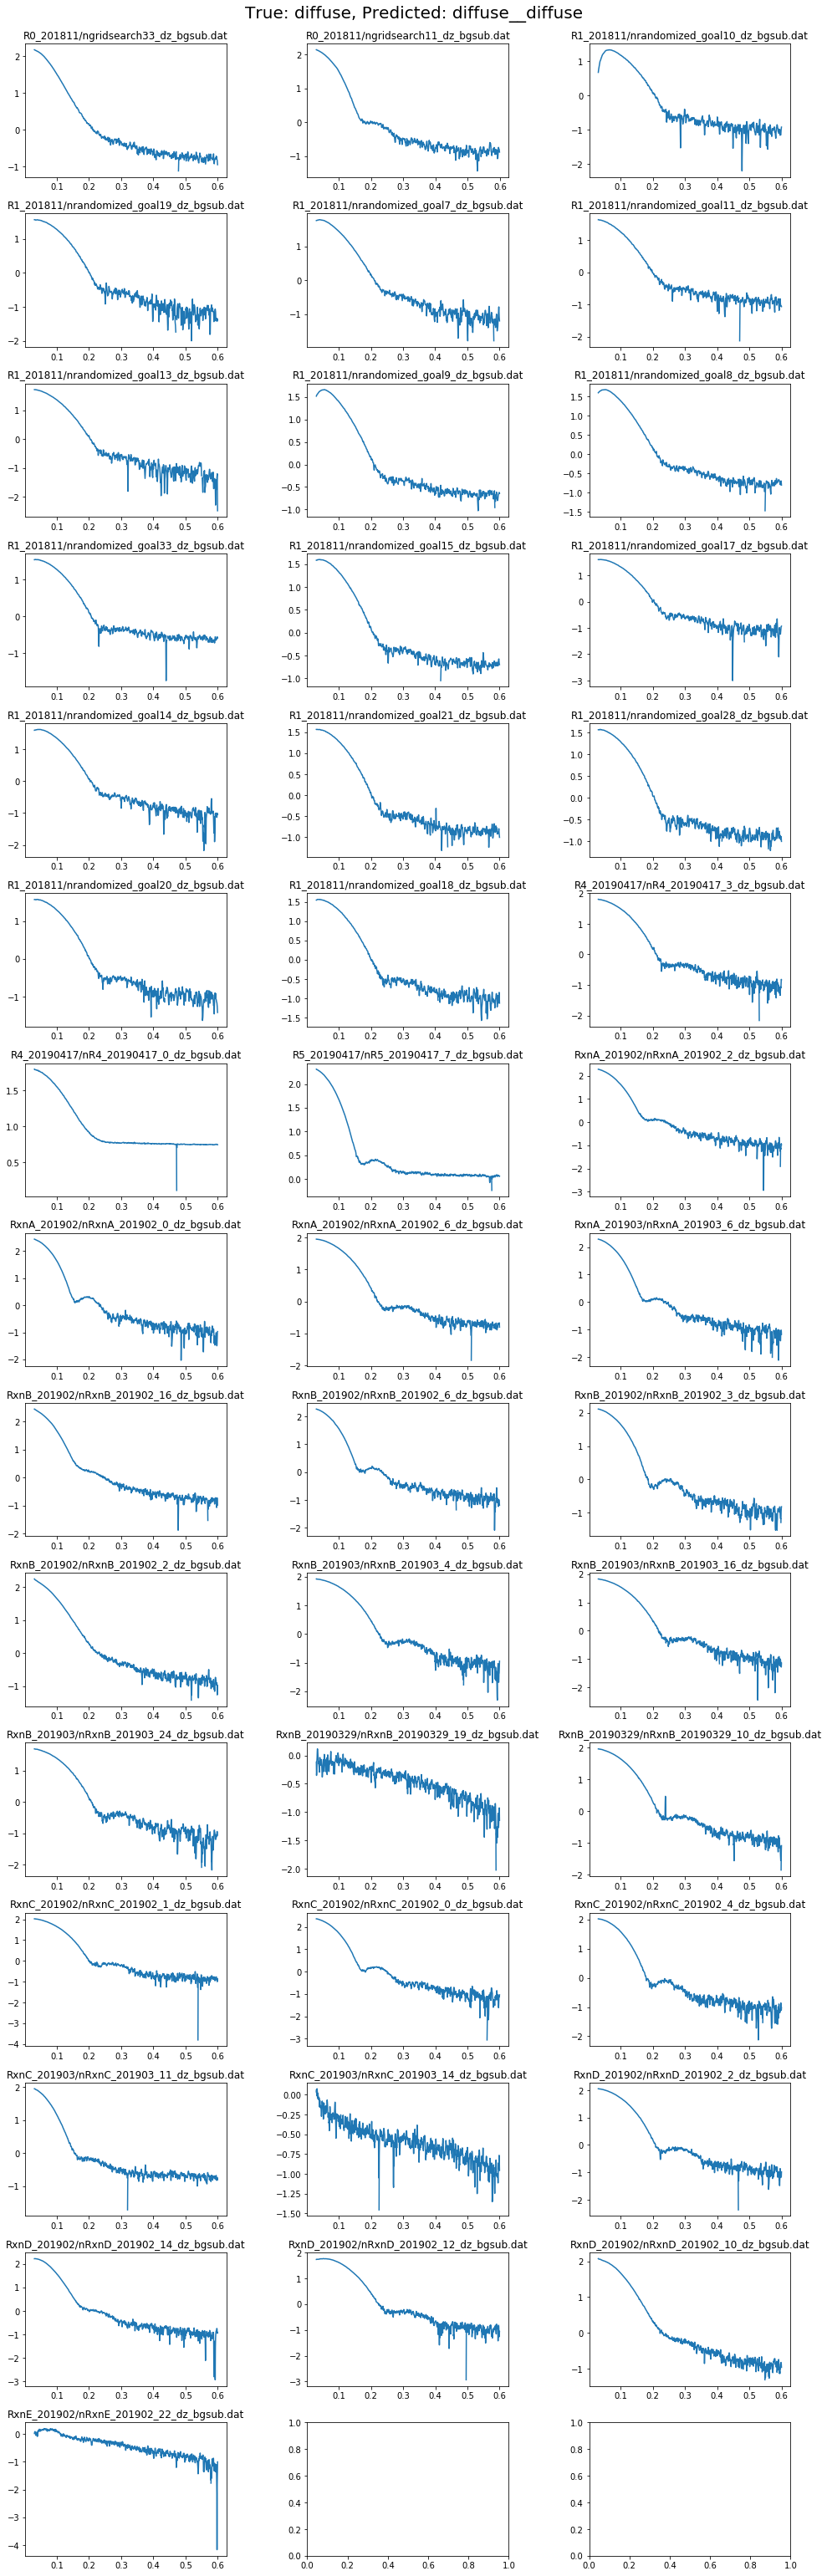

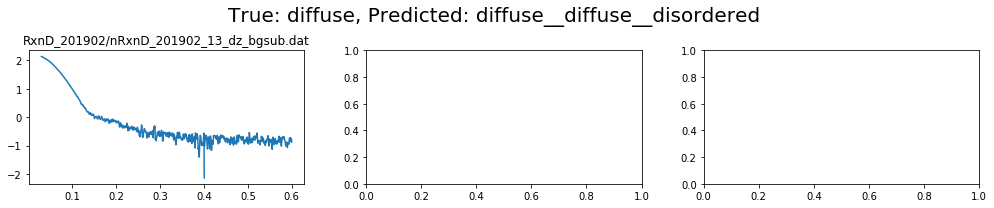

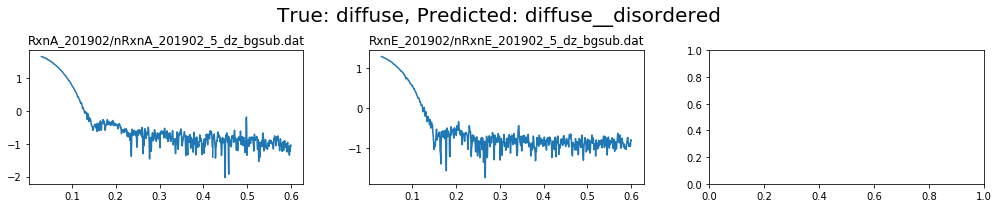

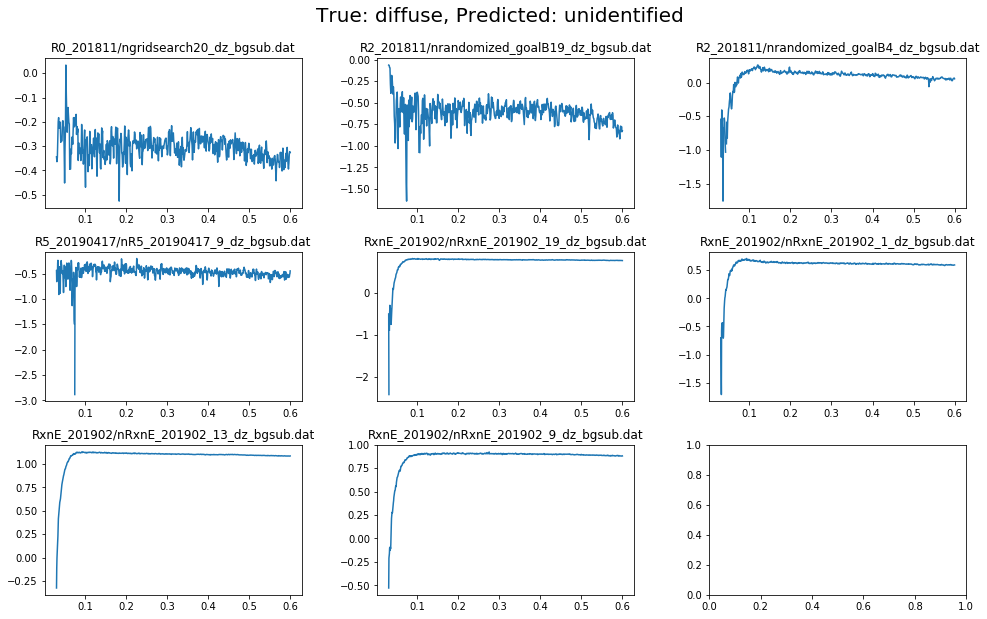

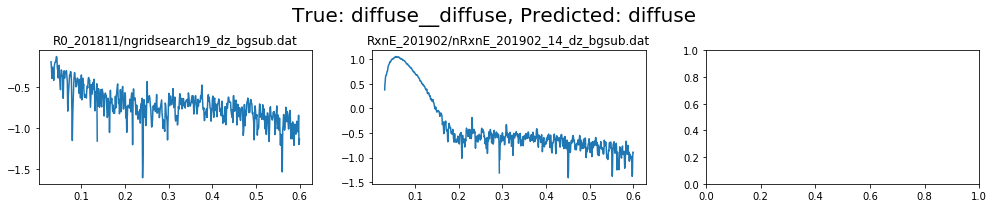

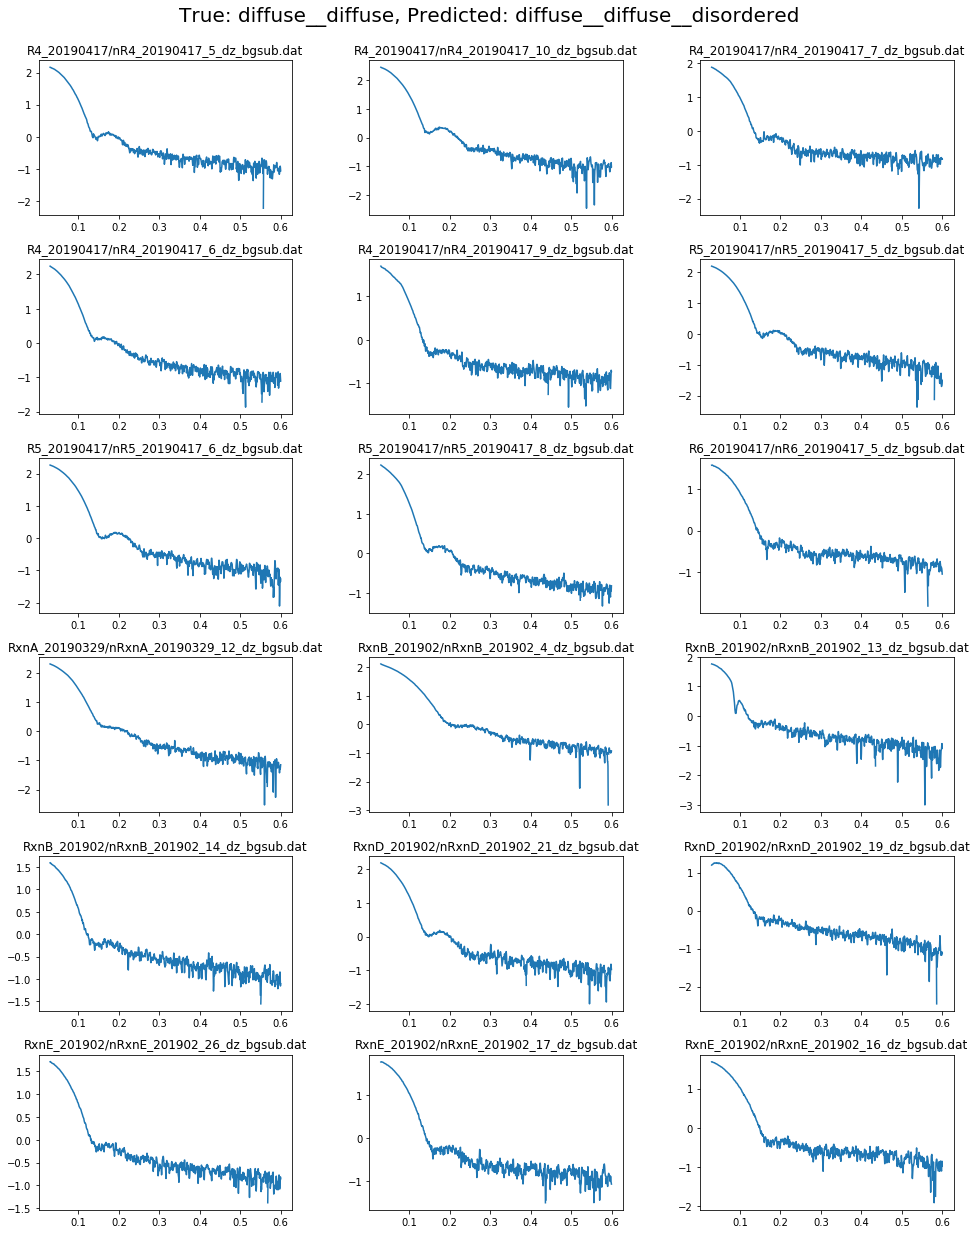

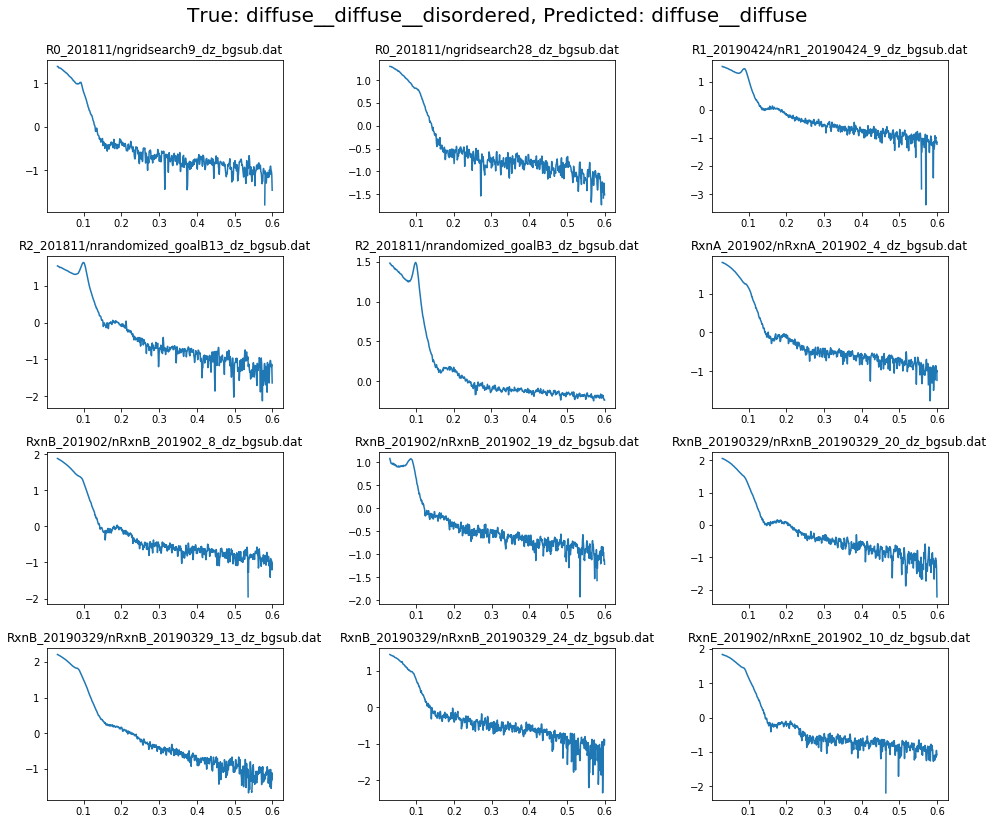

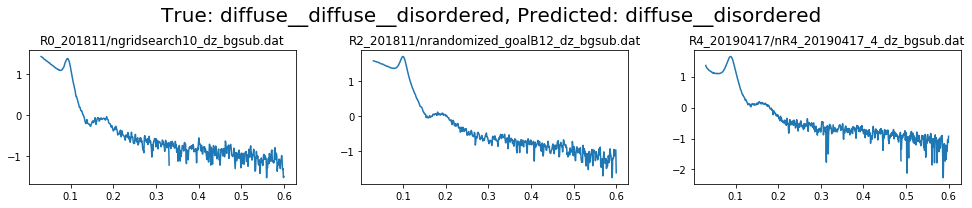

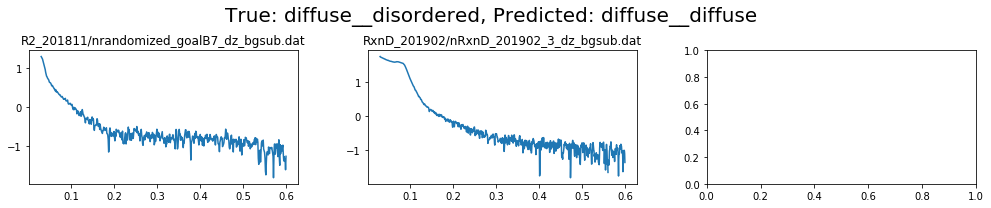

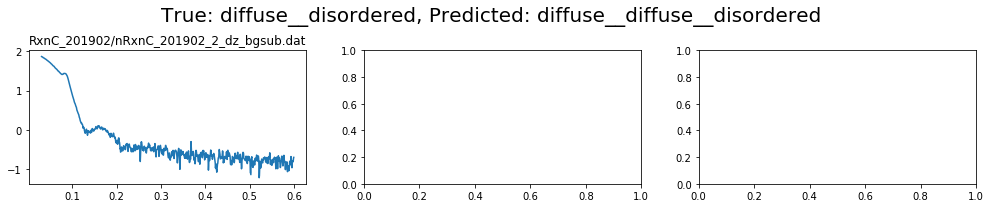

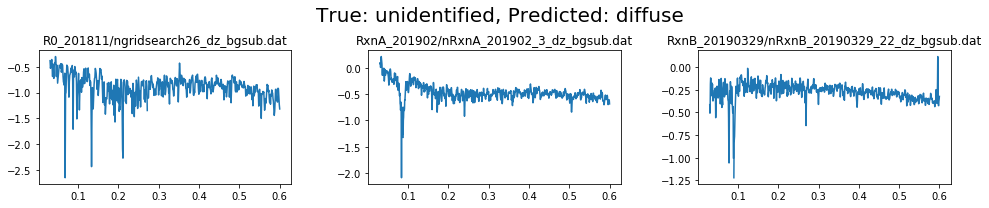

In [63]:
grs = missclassified.groupby(['system_class', 'system_class_pr'])
for name, gr in grs:
    ncols = 3
    nrows = len(gr)//3
    if len(gr)%3 !=0: nrows +=1
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,nrows*3))
    axs = axes.flatten()
    title = "True: " + name[0] + ", " + "Predicted: " + name[1]
    fig.suptitle(title, fontsize=20)
    #st.set_y(0.92)
    for n in range(len(gr)): 
        d = gr.iloc[n]
        exp = d['experiment_id']
        file_name = d['data_file']
        f = open('../xrsdkit_modeling/flowreactor_pd_nanoparticles/dataset/' + exp + '/' + file_name,'r')
        q_I = np.loadtxt(f,dtype=float)
        I_log = np.log10(q_I[:, 1])
        axs[n].plot(q_I[:, 0], I_log)
        axs[n].set_title(exp + "/n" + file_name)
    top = 0.1 / nrows**0.5
    fig.tight_layout(rect=[0, 0.03, 1, 1.0-top])